In [1]:
from sklearnex import patch_sklearn; patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from transformers import (AutoModelForSequenceClassification, pipeline)
import transformers
import datasets
from tqdm import tqdm
# from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request
import pandas as pd
from typing import Callable
from collections.abc import Iterable
import time
import seaborn as sns

/Users/elliotheisler/anaconda3/envs/cmpt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### format dataframes (could have done this in preprocessing notebook)

In [56]:
def format_reviews_df(df: pd.DataFrame): 
    df = df.copy()
    df['user_review'] = df['user_review'].fillna('').astype('string')
    df['title'] = df['title'].fillna('').astype('string')
    return df

def format_games_df(df: pd.DataFrame): 
    df = df.copy()
    df = df.astype({'title': 'string', 'developer': 'string',
               'publisher': 'string', 'tags': 'string',
               'overview': 'string'
              })
    return df
    
df = pd.read_csv('data/new_df.csv')
df = format_reviews_df(df)
df_games = pd.read_csv('data/train_gr/game_overview.csv')
df_games = format_games_df(df_games)

### merge game info columns from game_overview.csv

In [57]:
new_df = df.join(df_games.set_index('title'), on='title', lsuffix='_l', rsuffix='_r', validate='m:1')
new_df.tail(2)

,review_id,title,year,user_review,user_suggestion,is_early_access,received_free,contains_art,developer,publisher,tags,overview
17314,25536,EverQuest II,2017.0,"An older game, to be sure, but has its own cha...",1,False,False,False,Daybreak Game Company,Daybreak Game Company,"['Free to Play', 'Massively Multiplayer', 'RPG...",EverQuest® II is the epitome of massively mult...
17315,25537,EverQuest II,2011.0,When I frist started playing Everquest 2 it wa...,1,False,False,False,Daybreak Game Company,Daybreak Game Company,"['Free to Play', 'Massively Multiplayer', 'RPG...",EverQuest® II is the epitome of massively mult...


### complete analysis with 5 hyperparameters

In [7]:
from sklearn.metrics import confusion_matrix
from sklearnex.svm import SVC
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, r_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from time import time


### first hyperparameter: take sentiment scores from either the beginning, middle, or
### end of the steam review
confusions = {
    'left': [],
    'middle': [],
    'right': [],
}
for SELECTION in ['left', 'middle', 'right']:
    print(f'selection={SELECTION}')
    df_sentiments = pd.read_csv(f'data/results_{SELECTION}.csv')
    df_sentiments = pd.concat([new_df, df_sentiments], axis=1)
    
    ### take numeric columns, encode categorical columns
    
    le = LabelEncoder()
    oe = OrdinalEncoder().set_output(transform="pandas")
    
    numeric_df = df_sentiments.copy()
    numeric_df = numeric_df.drop(['review_id', 'tags', 'overview', 'user_review'], axis=1)
    # fit transforms for y and x
    numeric_df['user_suggestion'] = le.fit_transform(numeric_df['user_suggestion'])
    # x: string enums
    numeric_df[['title', 'developer', 'publisher']] = \
        oe.fit_transform(numeric_df[['title', 'developer', 'publisher']])
    # x: bools
    numeric_df[['is_early_access', 'received_free', 'contains_art']] = \
        oe.fit_transform(numeric_df[['is_early_access', 'received_free', 'contains_art']])
    
    ### correlation matrix
    
    hm = numeric_df.corr()
    hm.to_csv(f'results/corr_{SELECTION}.csv')
    
    ### split x and y, selkbest, standardscaler, and finally train/testsplit

    # x and y
    y = numeric_df['user_suggestion']
    x = numeric_df.drop('user_suggestion', axis=1)
    

    ### 2nd hyperparameter: `k` in selkbest
    
    for k in [x.columns.size, 5, 2]:
        print(f'  k={k}')
        # selkbest
        skb = SelectKBest(score_func=chi2, k=5).set_output(transform='pandas')
        best_x = skb.fit_transform(x, y)
        sorted(best_x.columns.to_list())
        
        # scaled
        scaler = StandardScaler()
        scaled_x = scaler.fit_transform(best_x)
        scaled_x = pd.DataFrame(scaled_x, columns=best_x.columns)
        
        x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.20)
        print('    at grid_search...')
        ### SVM grid search: the other 3 hyperparameters
        svm_paramgrid = {
        'kernel': ['linear', 'rbf', 'sigmoid'],
        'C': [1, 10, 1e-1],
        'gamma': ['scale', 'auto'],
            
        # 'shrinking': True,
        'cache_size': [1000]
        }
        svm_classifier = SVC()
        grid = GridSearchCV(svm_classifier, svm_paramgrid)
        
        t = time()
        grid.fit(x_train, y_train)
        print(f'grid search time: {time() - t}')

        ### test accuracy of best classifier
        y_pred = grid.predict(x_test)
        
        conf_matrix = confusion_matrix(y_test, y_pred)
        confusions[SELECTION].append(conf_matrix.tolist())
        
        gs_df = pd.DataFrame(grid.cv_results_)
        gs_df = gs_df.sort_values(by='mean_test_score', ascending=False)
        gs_df['param_selection'] = SELECTION
        gs_df['param_k'] = k
        gs_df.to_csv(f'results/gridsearch.csv', mode='a', index=False, 
                     header = True if SELECTION == 'left' and k == x.columns.size else False
                    )


selection=left
  k=10
    at grid_search...
grid search time: 147.4622519016266
  k=5
    at grid_search...
grid search time: 160.20049715042114
  k=2
    at grid_search...
grid search time: 149.9601809978485
selection=middle
  k=10
    at grid_search...
grid search time: 151.15001606941223
  k=5
    at grid_search...
grid search time: 158.39366388320923
  k=2
    at grid_search...
grid search time: 154.28762412071228
selection=right
  k=10
    at grid_search...
grid search time: 201.40812802314758
  k=5
    at grid_search...
grid search time: 155.06728386878967
  k=2
    at grid_search...
grid search time: 155.1328330039978


TypeError: file must have a 'write' attribute

In [10]:
import pickle
with open('results/confusions.pkl', 'wb') as f:
    pickle.dump(confusions, f)

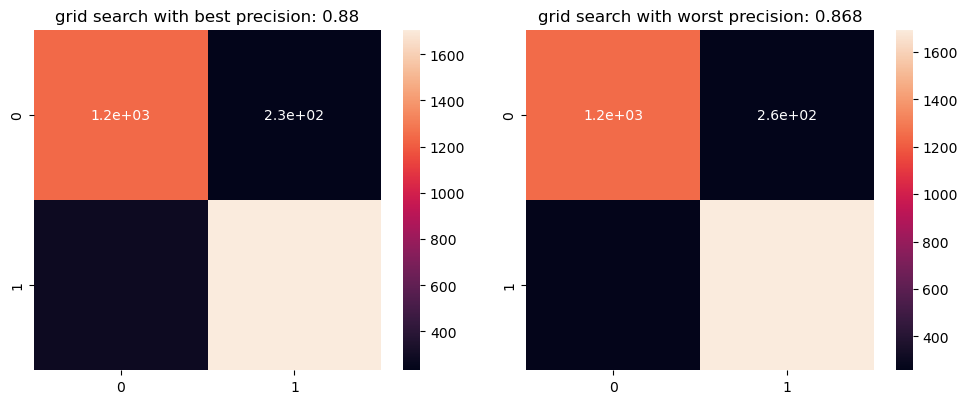

In [46]:
# i decided to make the figure right here
# best params, from output in figures.ipynb: selection=right, k=2
from matplotlib import pyplot as plt
least_accurate = np.array(confusions['middle'][1])
most_accurate = np.array(confusions['right'][0])
fig, axs = plt.subplots(1, 2, figsize=(10,4))
fig.tight_layout()

def precision(a):
    return a[1,1] / (a[1,1] + a[0,1])

sns.heatmap(most_accurate, annot=True, ax=axs[0])
sns.heatmap(least_accurate, annot=True, ax=axs[1])
axs[0].set_title(f'grid search with best precision: {precision(most_accurate):.3}')
axs[1].set_title(f'grid search with worst precision: {precision(least_accurate):.3}')
plt.savefig('results/final_results.png')

In [ ]:
# verifying the above
maxp = max(max(precision(np.array(a)) for a in l) for l in confusions.values())
minp = min(min(precision(np.array(a)) for a in l) for l in confusions.values())
print(maxp, minp)

k = None
i = None
min_val = None
min_key = None
min_idx = None
for k, l in confusions.items():
    for i in range(len(l)):
        val = precision(np.array(l[i]))
        if min_val is None or val > min_val:
            min_val = val
            min_key = k
            min_idx = i
print(min_val, min_key, min_idx)

In [58]:
df_sentiments = pd.read_csv(f'data/results_left.csv')
df_sentiments = pd.concat([new_df, df_sentiments], axis=1)

numeric_df = df_sentiments.copy()
numeric_df = numeric_df.drop(['review_id', 'tags', 'overview', 'user_review'], axis=1)